In [0]:
#Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Load Data
data=pd.read_csv("train.csv")


In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [40]:
data.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


In [41]:
data.shape

(550068, 12)

In [42]:
data.head(10)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969
5,1000003,P00193542,M,26-35,15,A,3,0,1,2.0,NaN,15227
6,1000004,P00184942,M,46-50,7,B,2,1,1,8.0,17.0,19215
7,1000004,P00346142,M,46-50,7,B,2,1,1,15.0,NaN,15854
8,1000004,P0097242,M,46-50,7,B,2,1,1,16.0,NaN,15686
9,1000005,P00274942,M,26-35,20,A,1,1,8,NaN,NaN,7871


In [43]:
data.dtypes

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                        int64
dtype: object

In [44]:
data['User_ID'].nunique()

5891

In [45]:
data['Product_ID'].nunique()

3631

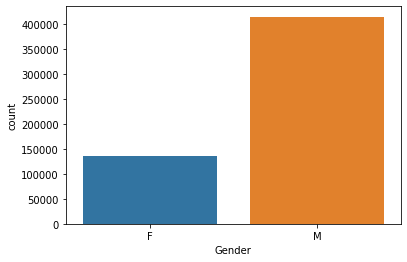

In [46]:
#%% Data visualizations

sns.countplot(data['Gender'])

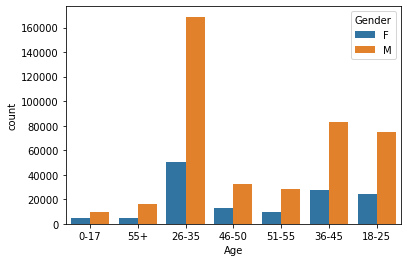

In [47]:
sns.countplot(data['Age'], hue=data['Gender'])
# histograms


<Figure size 1080x720 with 0 Axes>

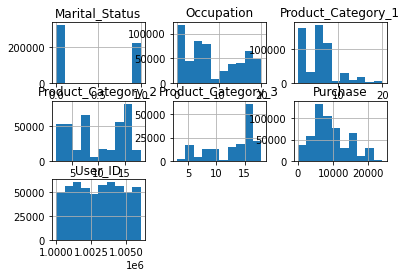

In [48]:
plt.figure(figsize=(15,10))
data.hist()
plt.show()

In [49]:
data['Occupation'].value_counts()

4     72308
0     69638
7     59133
1     47426
17    40043
20    33562
12    31179
14    27309
2     26588
16    25371
6     20355
3     17650
10    12930
5     12177
15    12165
11    11586
19     8461
13     7728
18     6622
9      6291
8      1546
Name: Occupation, dtype: int64

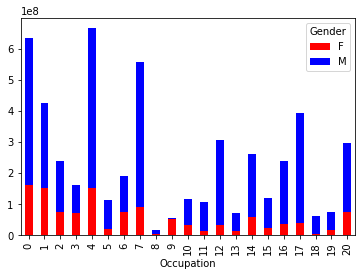

In [50]:
var = data.groupby(['Occupation','Gender']).Purchase.sum()
var.unstack().plot(kind='bar',stacked=True,color=['red','blue'])

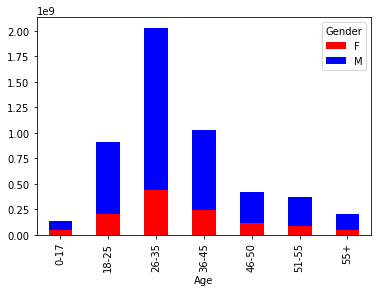

In [51]:
var = data.groupby(['Age','Gender']).Purchase.sum()
var.unstack().plot(kind='bar',stacked=True,color=['red','blue'])

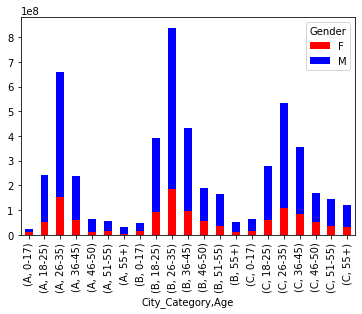

In [52]:
var = data.groupby(['City_Category','Age','Gender']).Purchase.sum()
var.unstack().plot(kind='bar',stacked=True,color=['red','blue'])

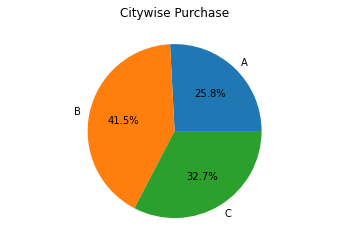

In [53]:
var = data.groupby(['City_Category']).sum().stack()
temp=var.unstack()
type(temp)
x_list=temp['Purchase']
label_list=temp.index
plt.axis("equal")

plt.pie(x_list,labels=label_list,autopct="%1.1f%%")
plt.title("Citywise Purchase")
plt.show()

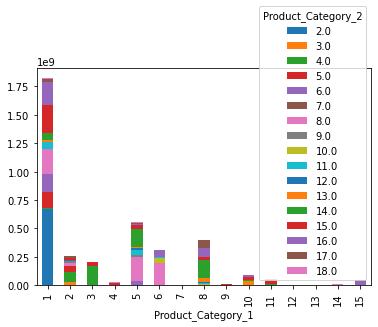

In [54]:
var = data.groupby(['Product_Category_1','Product_Category_2']).Purchase.sum()
var.unstack().plot(kind='bar',stacked=True)

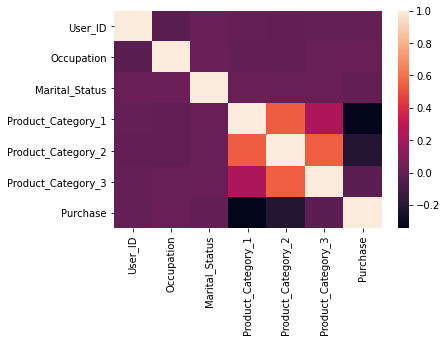

In [55]:
sns.heatmap(data.corr())

In [56]:
df=pd.get_dummies(data,columns=['Occupation','City_Category','Age','Stay_In_Current_City_Years','Gender'], drop_first=True)
df.head(5)

,User_ID,Product_ID,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5,Occupation_6,Occupation_7,Occupation_8,Occupation_9,Occupation_10,Occupation_11,Occupation_12,Occupation_13,Occupation_14,Occupation_15,Occupation_16,Occupation_17,Occupation_18,Occupation_19,Occupation_20,City_Category_B,City_Category_C,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+,Gender_M
0,1000001,P00069042,0,3,NaN,NaN,8370,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1000001,P00248942,0,1,6.0,14.0,15200,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,1000001,P00087842,0,12,NaN,NaN,1422,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1000001,P00085442,0,12,14.0,NaN,1057,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1000002,P00285442,0,8,NaN,NaN,7969,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1


In [57]:
df=df.drop(['User_ID','Product_ID','Product_Category_3'], axis = 1 )
df.head(5)

,Marital_Status,Product_Category_1,Product_Category_2,Purchase,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5,Occupation_6,Occupation_7,Occupation_8,Occupation_9,Occupation_10,Occupation_11,Occupation_12,Occupation_13,Occupation_14,Occupation_15,Occupation_16,Occupation_17,Occupation_18,Occupation_19,Occupation_20,City_Category_B,City_Category_C,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+,Gender_M
0,0,3,NaN,8370,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,1,6.0,15200,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,12,NaN,1422,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,12,14.0,1057,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,8,NaN,7969,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1


In [58]:
data.groupby('Product_Category_1')['Product_Category_2'].describe()

,count,mean,std,min,25%,50%,75%,max
Product_Category_1,,,,,,,,
1,133780.0,7.743325,5.626177,2.0,2.0,6.0,15.0,18.0
2,22934.0,6.656536,4.209569,3.0,4.0,5.0,8.0,18.0
3,19974.0,4.490588,1.812214,4.0,4.0,4.0,4.0,15.0
4,11610.0,5.992851,1.861664,5.0,5.0,5.0,8.0,15.0
5,87233.0,10.947428,3.245717,6.0,8.0,11.0,14.0,18.0
6,19473.0,10.036718,3.152101,8.0,8.0,8.0,10.0,16.0
7,300.0,12.513333,3.524850,8.0,8.0,12.0,17.0,17.0
8,53165.0,14.645255,1.663547,9.0,14.0,14.0,16.0,18.0
9,409.0,15.000000,0.000000,15.0,15.0,15.0,15.0,15.0


In [59]:
data.groupby('Product_Category_1')['Product_Category_2'].median().apply(np.floor)



Product_Category_1
1      6.0
2      5.0
3      4.0
4      5.0
5     11.0
6      8.0
7     12.0
8     14.0
9     15.0
10    15.0
11    15.0
12    14.0
13    16.0
14    16.0
15    16.0
16     NaN
17     NaN
18     NaN
19     NaN
20     NaN
Name: Product_Category_2, dtype: float64

In [60]:
data.groupby('Product_Category_1')['Product_Category_2'].mean().apply(np.ceil)

Product_Category_1
1      8.0
2      7.0
3      5.0
4      6.0
5     11.0
6     11.0
7     13.0
8     15.0
9     15.0
10    15.0
11    16.0
12    15.0
13    16.0
14    17.0
15    17.0
16     NaN
17     NaN
18     NaN
19     NaN
20     NaN
Name: Product_Category_2, dtype: float64

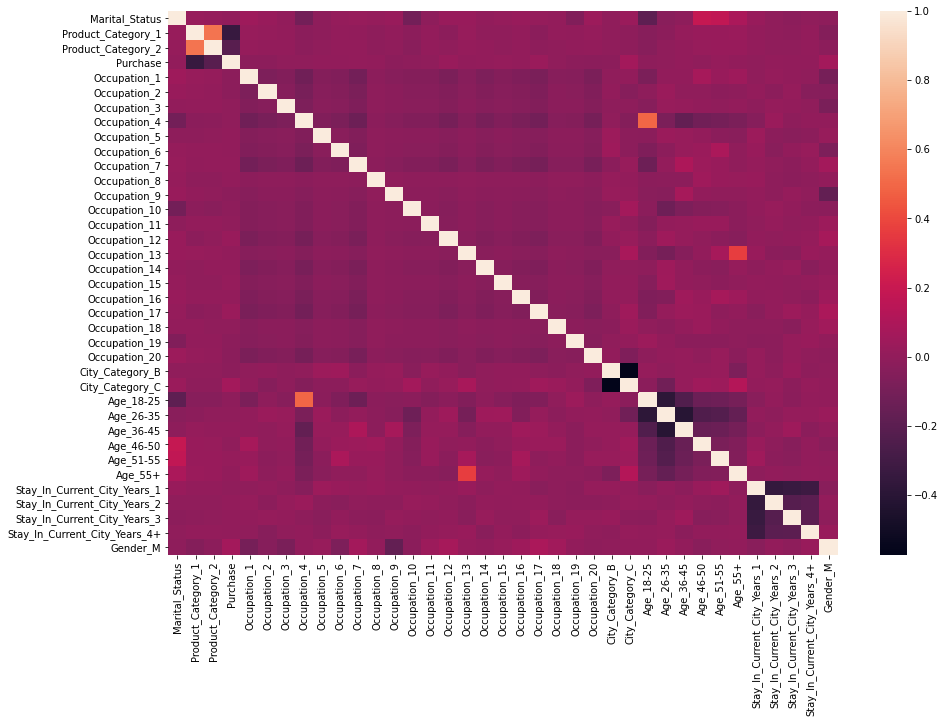

In [61]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr())

In [62]:
df.head(5)

,Marital_Status,Product_Category_1,Product_Category_2,Purchase,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5,Occupation_6,Occupation_7,Occupation_8,Occupation_9,Occupation_10,Occupation_11,Occupation_12,Occupation_13,Occupation_14,Occupation_15,Occupation_16,Occupation_17,Occupation_18,Occupation_19,Occupation_20,City_Category_B,City_Category_C,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+,Gender_M
0,0,3,NaN,8370,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,1,6.0,15200,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,12,NaN,1422,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,12,14.0,1057,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,8,NaN,7969,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1


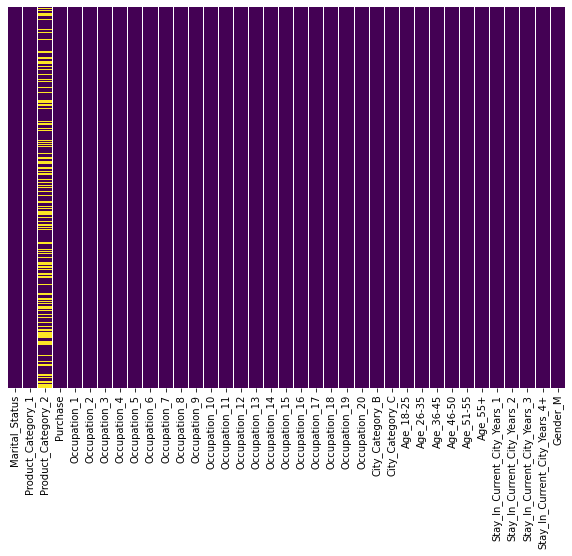

In [63]:
plt.figure(figsize=(10,7))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

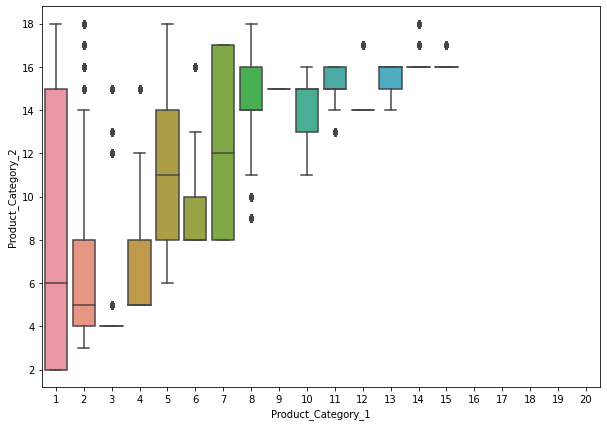

In [64]:
plt.figure(figsize=(10,7))
sns.boxplot(x='Product_Category_1',y='Product_Category_2',data=df)

In [0]:
def impute_cat2(cols):
    cat2=cols[1]
    cat1=cols[0]
    if pd.isnull(cat2):
      if cat1 == 1:
        return 8
      elif cat1 == 2:  
        return 7
      elif cat1 == 3: 
        return 5
      elif cat1 == 4:
        return 6
      elif cat1 == 5: 
        return 11
      elif cat1 == 6: 
        return 11
      elif cat1 == 7: 
        return 13
      elif cat1 == 8: 
        return 15
      elif cat1 == 9: 
        return 15
      elif cat1 == 10: 
        return 15
      elif cat1 == 11: 
        return 16
      elif cat1 == 12: 
        return 15
      elif cat1 == 13: 
        return 16
      elif cat1 == 14: 
        return 17
      elif cat1 == 15: 
        return 17
      else :
        return  0
    else:
      return cat2

In [0]:
df['Product_Category_2']=df[['Product_Category_1','Product_Category_2']].apply(impute_cat2,axis=1)

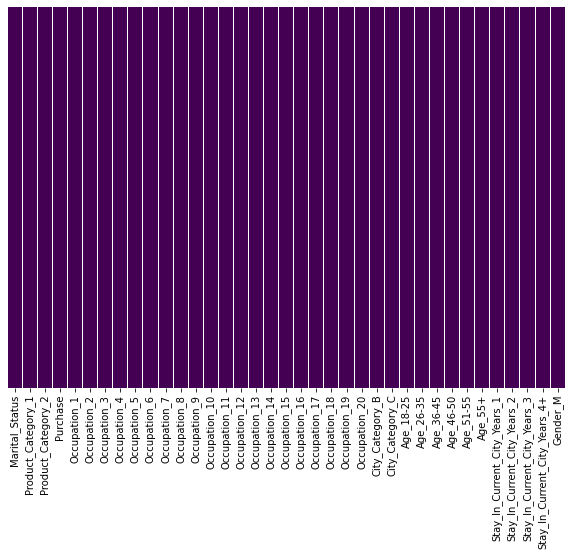

In [67]:
plt.figure(figsize=(10,7))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')